In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

In [8]:
TRAIN_PATH = r"..\datasets\CreditCard\UCI_Credit_Card.csv"
train_df = pd.read_csv(TRAIN_PATH)

X, y = train_df.values[:, :-1], train_df.values[:, -1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [10]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1

    Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
   
        

In [11]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.766000
Error Rate: 0.23399999999999999
Mean Recall: 0.5335789575703939
Balanced Accuracy Score: 0.5335789575703939
Precision: 0.5958578990908425
F-Score: 0.5221836344037767
Selectivity: 0.9503530922319708
G_mean: 0.7121014058945083


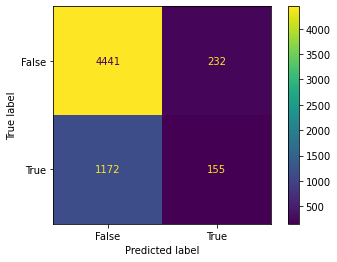

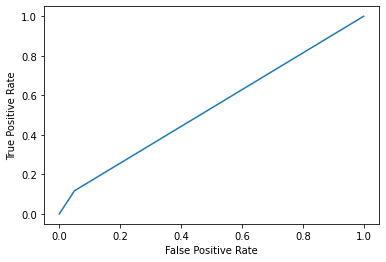

In [12]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.607833
Error Rate: 0.39216666666666666
Mean Recall: 0.5583008967321935
Balanced Accuracy Score: 0.5583008967321935
Precision: 0.5426832723810675
F-Score: 0.5330607878585487
Selectivity: 0.647121763321207
G_mean: 0.6010729246581883


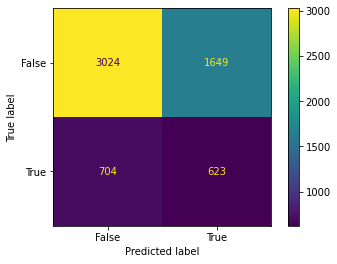

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.605833
Error Rate: 0.39416666666666667
Mean Recall: 0.557556509190106
Balanced Accuracy Score: 0.557556509190106
Precision: 0.5420239781769954
F-Score: 0.5318650920310671
Selectivity: 0.6441258292317569
G_mean: 0.5992800253851622


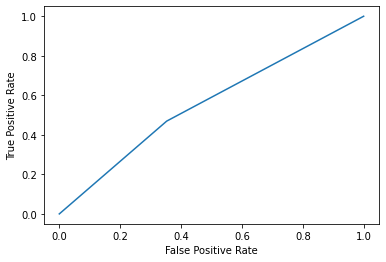

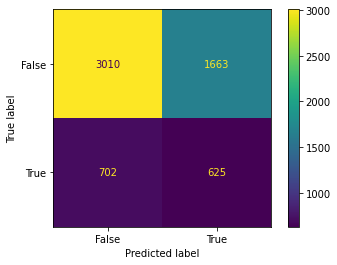

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.609833
Error Rate: 0.39016666666666666
Mean Recall: 0.5612036211164169
Balanced Accuracy Score: 0.5612036211164169
Precision: 0.5448084159463217
F-Score: 0.5354421183072088
Selectivity: 0.6484057350738284
G_mean: 0.6032310058974791


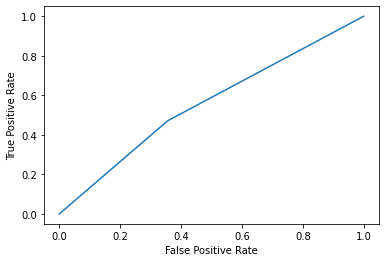

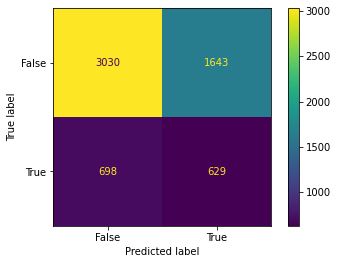

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.605667
Error Rate: 0.3943333333333333
Mean Recall: 0.5582588878598552
Balanced Accuracy Score: 0.5582588878598552
Precision: 0.5424871883076217
F-Score: 0.5321817191273877
Selectivity: 0.6432698480633426
G_mean: 0.599258800497431


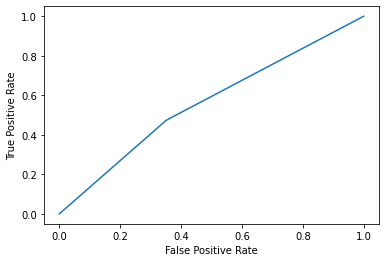

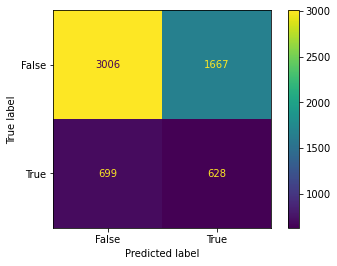

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.609667
Error Rate: 0.3903333333333333
Mean Recall: 0.5670320497862386
Balanced Accuracy Score: 0.5670320497862386
Precision: 0.5487103725535714
F-Score: 0.5385110129427102
Selectivity: 0.6434838433554462
G_mean: 0.6040496359589711


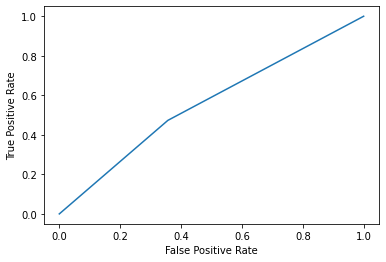

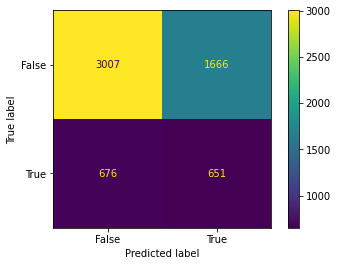

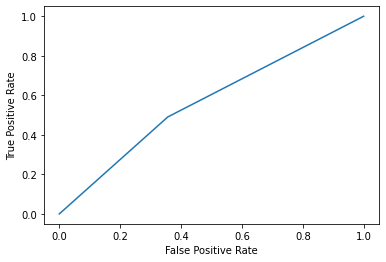

In [13]:
sm_list = []
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))

for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.616500
Error Rate: 0.38349999999999995
Mean Recall: 0.568451240116425
Balanced Accuracy Score: 0.568451240116425
Precision: 0.550272020412427
F-Score: 0.5420658429446381
Selectivity: 0.654611598544832
G_mean: 0.6100121105251969


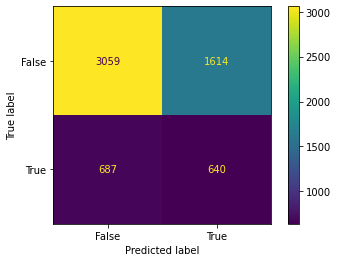

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.609500
Error Rate: 0.39049999999999996
Mean Recall: 0.5666552600349197
Balanced Accuracy Score: 0.5666552600349197
Precision: 0.5484443300535012
F-Score: 0.5382424920636866
Selectivity: 0.6434838433554462
G_mean: 0.6038489087386429


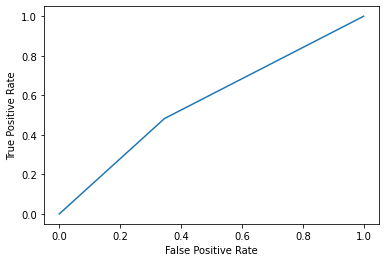

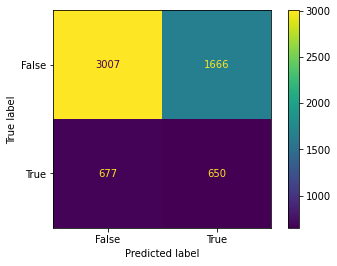

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.607167
Error Rate: 0.39283333333333337
Mean Recall: 0.5648875008849278
Balanced Accuracy Score: 0.5648875008849278
Precision: 0.5470697729263527
F-Score: 0.5363426906844782
Selectivity: 0.6407019045580997
G_mean: 0.601601610435044


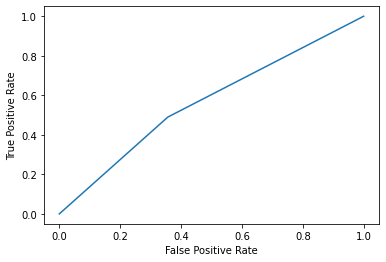

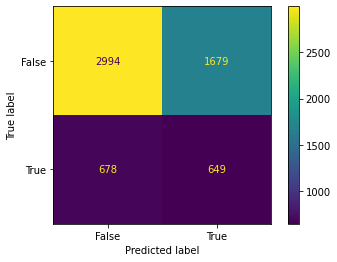

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.617333
Error Rate: 0.3826666666666667
Mean Recall: 0.569256020451951
Balanced Accuracy Score: 0.569256020451951
Precision: 0.5508900996433345
F-Score: 0.5428406981688009
Selectivity: 0.6554675797132463
G_mean: 0.6108427506018506


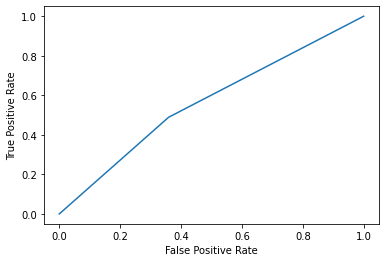

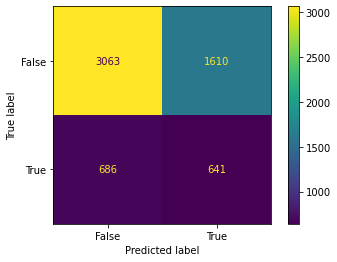

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.619667
Error Rate: 0.3803333333333333
Mean Recall: 0.5664373138124044
Balanced Accuracy Score: 0.5664373138124044
Precision: 0.5492332374319951
F-Score: 0.5422110071571825
Selectivity: 0.6618874384763536
G_mean: 0.6123052692054175


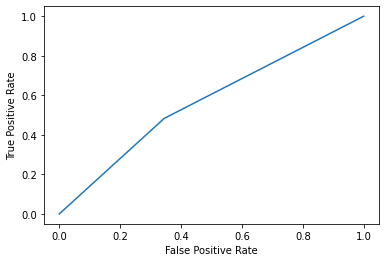

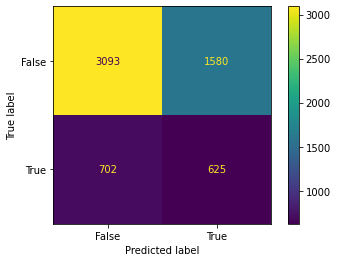

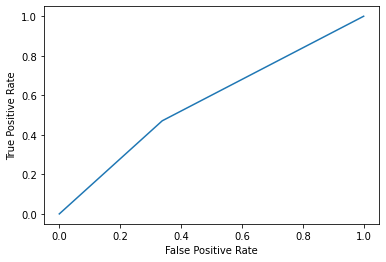

In [14]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)